In [1]:
# Install required packages
!pip install torch transformers datasets trl==0.11.3 matplotlib

In [2]:

import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import os
os.environ["WANDB_DISABLED"] = "true"
from datasets import load_dataset
from trl import PPOTrainer, PPOConfig
from trl.models.modeling_value_head import AutoModelForCausalLMWithValueHead
from transformers import AutoModelForCausalLM


In [3]:
# Configuration
config = PPOConfig(
    model_name="gpt2-medium",
    learning_rate=1e-5,
    batch_size=16,
    log_with=None,
    mini_batch_size=4,
    gradient_accumulation_steps=1,
    optimize_cuda_cache=True,
    target_kl=8.0,
    ppo_epochs=2
)

sent_kwargs = {"candidate_labels": ["humorous", "not humorous"]}


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


In [4]:
# Load Humor Dataset
dataset = load_dataset("CreativeLang/ColBERT_Humor_Detection", split="train")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

def preprocess(sample):
    ids = tokenizer.encode(sample["text"], truncation=True, max_length=64)
    sample["input_ids"] = ids
    sample["query"] = tokenizer.decode(ids)
    return sample

dataset = dataset.filter(lambda x: x["humor"] == True)
dataset = dataset.shuffle(seed=42).select(range(5000))
dataset = dataset.map(preprocess)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Data collator
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])



In [6]:
# Load GPT2 model with value head
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  21%|##        | 315M/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [7]:
# Initialize PPOTrainer
ppo_trainer = PPOTrainer(
    config=config,
    model=model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=dataset,
    data_collator=collator
)

device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"


/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(


In [8]:

# Load pretrained humor classifier as reward model
reward_tokenizer = AutoTokenizer.from_pretrained("thanawan/bert-base-uncased-finetuned-humordetection")
reward_model = AutoModelForSequenceClassification.from_pretrained("thanawan/bert-base-uncased-finetuned-humordetection")
sentiment_pipe = pipeline("text-classification", model=reward_model, tokenizer=reward_tokenizer, device=device, return_all_scores=True)



tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:

# PPO Training loop
gen_kwargs = {"min_length": -1, "top_k": 50, "top_p": 0.95, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}
reward_trend = []

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader), total=500):
    query_tensors = [torch.tensor(q).to(device) for q in batch["input_ids"]]

    response_tensors = []
    for query in query_tensors:
        query_tensor = torch.tensor(query).to(device)
        response = ppo_trainer.generate(query_tensor, **gen_kwargs)
        response_tensors.append(response.squeeze())

    batch["response"] = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors]

    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, batch_size=16)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    reward_trend.append(torch.stack(rewards).mean().item())


  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-9-b36a4dc18438>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_tensor = torch.tensor(query).to(device)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

  1%|          | 3/500 [00:30<1:23:59, 10.14s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1313: UserWarning: KL divergence is starting to become negative: -1.24 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
  5%|▍         | 23/500 [03:35<1:07:30,  8.49s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (12.13) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
  5%|▌         | 26/500 [03:58<1:03:15,  8.01s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:1246: UserWarning: The average ratio of batch (27404.61) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
  9%|▉         | 47/500 [06:46<1:02:38,  8.30s/it]/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_

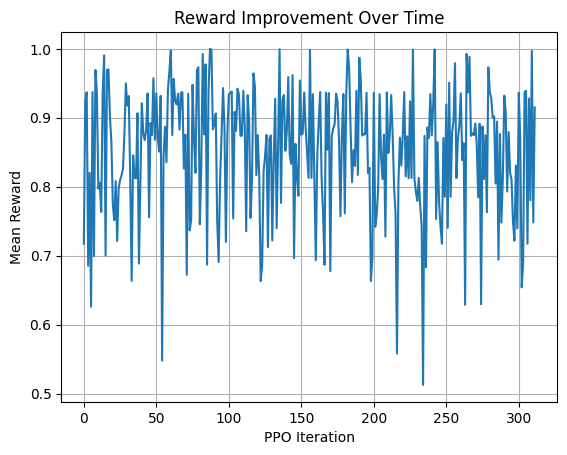

In [10]:

# Plot reward improvement
plt.plot(reward_trend)
plt.xlabel("PPO Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward Improvement Over Time")
plt.grid()
plt.show()


In [11]:
# Generate single example for before/after comparison
prompt = "This movie was"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
ref_output = ref_model.generate(input_ids, max_new_tokens=50, **gen_kwargs)
model_output = model.generate(input_ids, max_new_tokens=50, **gen_kwargs)

ref_text = tokenizer.decode(ref_output[0], skip_special_tokens=True)
model_text = tokenizer.decode(model_output[0], skip_special_tokens=True)

print("Before fine-tuning:\n", ref_text)
print("\nAfter fine-tuning:\n", model_text)


Before fine-tuning:
 This movie was pretty decent, with some problems, but not enough.


The characters didn't feel like their main plot was developed enough and there was some bad plotting going on. So I am not expecting many good characters in the rest of the films or series

After fine-tuning:
 This movie was about people who, even with their flaws, make the best of their lives -- like the characters in The Lion King who got a second chance, or any time in the last 20 years.

With all that in mind --- I've read the


In [12]:
# Evaluate on batch with table display
import random
bs = 8
sample_batch = dataset.shuffle(seed=42).select(range(bs)).with_format("pandas")
df_batch = sample_batch[:bs]
game_data = dict()
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

for i in range(bs):
    gen_len = 30
    output = ref_model.generate(torch.tensor(query_tensors[i]).unsqueeze(0).to(device), max_new_tokens=gen_len, **gen_kwargs).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(torch.tensor(query_tensors[i]).unsqueeze(0).to(device), max_new_tokens=gen_len, **gen_kwargs).squeeze()[-gen_len:]
    response_tensors.append(output)

game_data["response (before)"] = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors_ref]
game_data["response (after)"] = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors]

texts_before = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts_before, batch_size=8)]

texts_after = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts_after, batch_size=8)]


In [13]:
# Convert to DataFrame and display
reward_df = pd.DataFrame(game_data)
print("\n=== Reward Table Comparison ===")
display(reward_df[["query", "response (before)", "response (after)", "rewards (before)", "rewards (after)"]])
print("\nReward Means:")
print(reward_df[["rewards (before)", "rewards (after)"]].mean())
print("\nReward Medians:")
print(reward_df[["rewards (before)", "rewards (after)"]].median())


=== Reward Table Comparison ===


,query,response (before),response (after),rewards (before),rewards (after)
0,I used to know a great joke about a boomarang....,It'll come back. The booms always do it. Ther...,"I'll be damned.""\n\nAfter the booms, he says ...",0.999786,0.999893
1,I'm putting my standards up for adoption becau...,".""\n\nHe explained that he only wants a job th...",". Also, i know a lot of people who have gone t...",0.002076,0.999279
2,"Was billy idol? no, he was moving at the time.",Thats like saying he didn't love you or what ...,\n\n\nLOL.\n\nIf you're wondering how that wor...,0.999761,0.999884
3,"Girl, are you an hm move? 'cause i can't seem ...",-Oh you have this? You've never been to a dan...,"'t's a little hard to swallow, so t will not ...",0.093313,0.000103
4,Sometimes i feel so lucky to be american... no...,lol.\n\nI used to know a guy that just ran up...,that i hope the i hope they like me more beca...,0.999797,0.999803
5,I like to paint pictures of ww2 bombers onto t...,"And even though it's not really a big deal, i...",When the planes run out of fuel then we go ba...,0.999762,0.999866
6,What do you call a friendly mancunian midwife?...,. There's probably a little more to it than th...,.\n\nThe sound is most commonly associated wit...,0.999902,0.999815
7,"What's 5,000 lbs and sexually confused? a bi-n...",and her female chimp mate in the wild: A stud...,"?""\n\n""When do they become men?"" See?\n\n""I'll...",0.004523,0.999837



Reward Means:
rewards (before)    0.637365
rewards (after)     0.874810
dtype: float64

Reward Medians:
rewards (before)    0.999762
rewards (after)     0.999826
dtype: float64


In [14]:
# User input prompt evaluation
print("\n=== Custom Prompt Evaluation ===")
user_prompt = input("Enter a prompt: ")
input_ids = tokenizer.encode(user_prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_new_tokens=50, **gen_kwargs)
print("\nModel Response:", tokenizer.decode(output[0], skip_special_tokens=True))


=== Custom Prompt Evaluation ===
Enter a prompt: the cup of water is cold

Model Response: the cup of water is cold to touch). And this is the reason why the first law--that the earth has not started over on us---is so false. Now the moon is made of carbon. And that also is good (contrasting with our belief in the law


In [ ]:
# User input prompt evaluation loop
print("\n=== Custom Prompt Evaluation ===")
while True:
    user_prompt = input("Enter a prompt (or type 'exit' to quit): ")
    if user_prompt.strip().lower() == 'exit':
        print("Exiting prompt loop.")
        break
    input_ids = tokenizer.encode(user_prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, max_new_tokens=50, **gen_kwargs)
    print("\nModel Response:", tokenizer.decode(output[0], skip_special_tokens=True))



=== Custom Prompt Evaluation ===
Enter a prompt (or type 'exit' to quit): Why did the computer get cold?

Model Response: Why did the computer get cold?

I think it had been a while since I was the first owner.

The first owner?

The first owner is now dead? Wow....why don't you just call me "Polly" for a few hours? {
Enter a prompt (or type 'exit' to quit): The WiFi was down for 5 minutes, so I had to...

Model Response: The WiFi was down for 5 minutes, so I had to... "What the hell is happening?!" "That sounds good. What's happening is a sign! "Huh? "You mean it didn't work in the first place, did it?" -Right... "I don't know if it was. "
Enter a prompt (or type 'exit' to quit): If I had a dollar for every bug I fixed...

Model Response: If I had a dollar for every bug I fixed...I might have had a whole lot more cash for them." - Mike

The guy at the counter didn't seem like much of a customer. He looked pretty upset about the lack of money. I have two older children, so I was a
Ent